# Contexto

La industria ha ido evolucionando a lo largo del tiempo, desde el siglo XVIII, cuando surgieron las primeras máquinas que reemplazaron el trabajo manual de los trabajadores, hasta hoy, cuando siguen surgiendo nuevas tecnologías para facilitar, mejorar y optimizar el rendimiento en la fabricación y el mantenimiento de sistemas industriales (Universidad de Deusto, s. f.). 

Tradicionalmente, estos avances se han enfocado en procesos repetitivos o  de producción masiva, como la fabricación de tornillos, puertas o componentes mecánicos. Sin embargo, en las últimas décadas, la digitalización y la inteligencia artificial han abierto la puerta a aplicar los mismos principios de optimización en sectores más complejos y críticos, como la industria aeronáutica.

En este ámbito, los helicópteros son un caso especialmente interesante, pues su funcionamiento depende de sistemas muy sensibles, los cuales están sometidos a grandes esfuerzos mecánicos y donde cualquier fallo puede repercutir en consecuencias graves. Es por esto que es de vital importancia ser capaz de **detectar y predecir fallos en uno de los componentes más importantes del helicóptero, como son los motores** (corazón de helicóptero), permitiendo así mejorar la seguridad y la eficiencia en su construcción.


# Primeros pasos

Recomendamos crear un entorno virtual e instalar las dependencias necesarias para poder ejecutar el notebook. Para facilitar este paso, hemso creado un *requirements.txt*. Pasos a seguir:
> python3 -m venv nombre_entorno

> source nombre_entorno\bin\activate

> pip install -r requirements.txt

# Importación de Dependencias

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


import importlib
import utils
import plots
importlib.reload(utils)
importlib.reload(plots)



<module 'plots' from '/home/haizea_gonzalez/Cuarto/analitica/Proyecto/analitica_turboshaft/plots.py'>

# Preparación de Datos

En esta primera fase cargaremos y analizaremos la información básica de los datos del dataset escogido de kaggle:
> https://www.kaggle.com/datasets/ziya07/helicopter-turboshaft-detection-dataset

## Carga y Exploración Inicial

In [43]:
file_name = "data/Helicopter_Turboshaft_Fault_Detection.csv"

try:
    #Cargar dataset
    df = pd.read_csv(file_name)
    print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    print(f"No se ha encontrado el archivo {file_name} en la carpeta del proyecto")
except Exception as e:
    print(f"Error cargando el archivo: {e}")

Dataset cargado: 7012 filas, 11 columnas


In [44]:
#Informacion basica
print("\nINFORMACIÓN DEL DATASET:")
print(df.info())


INFORMACIÓN DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             7012 non-null   object 
 1   Temp_Compressor       7012 non-null   float64
 2   Temp_Turbine          7012 non-null   float64
 3   Pressure_Compressor   7012 non-null   float64
 4   Vibration_Compressor  7012 non-null   float64
 5   Speed_Turbine         7012 non-null   float64
 6   Fuel_Flow             7012 non-null   float64
 7   Altitude              7012 non-null   float64
 8   Airspeed              7012 non-null   float64
 9   Ambient_Temp          7012 non-null   float64
 10  Fault_Label           7012 non-null   object 
dtypes: float64(9), object(2)
memory usage: 602.7+ KB
None


Podemos observar que los datos coinciden con la descripción proporcionada en Kaggle, ya que el conjunto cuenta con 11 columnas, una de las cuales corresponde a la etiqueta de error. En general, las columnas presentan los tipos de datos adecuados (numéricos y de texto), aunque la columna timestamp se encuentra actualmente como tipo string, por lo que será necesario convertirla a un formato de fecha y hora apropiado.

Para inspeccionar un poco más en profundidad, mostramos las primeras filas del conjunto de datos:

In [45]:
print("\nPRIMERAS FILAS:")
df.head()


PRIMERAS FILAS:


,Timestamp,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp,Fault_Label
0,2024-03-01 00:00:00,0.516699,-0.482741,1.218923,0.439431,1.109674,0.259894,-0.457097,0.935177,0.520473,Normal
1,2024-03-01 01:00:00,-0.137372,-1.071038,-0.581229,0.165394,-0.344521,0.381376,1.416960,-0.804455,-0.461119,Normal
2,2024-03-01 02:00:00,0.672213,-0.867799,0.268908,1.551952,1.156725,0.647181,0.053060,-1.435661,-1.606553,Normal
3,2024-03-01 03:00:00,1.573874,-1.351055,0.142967,0.176228,0.047683,-1.703167,-1.739264,-0.980834,0.247414,Normal
4,2024-03-01 04:00:00,-0.236144,-0.949079,-1.116520,0.251032,0.122548,-0.376294,0.681555,0.341163,-1.328883,Turbine Blade Damage


Obtenemos las estadísticas descriptivas básicas para tener una visión general de la distribución de los datos, incluyendo medidas como la media, mediana, desviación estándar, valores mínimos y máximos, y cuartiles.

In [46]:
print("\nESTADÍSTICAS DESCRIPTIVAS:")
df.describe()


ESTADÍSTICAS DESCRIPTIVAS:


,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp
count,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03
mean,-1.045750e-15,-2.294165e-15,-4.245827e-16,1.504786e-16,6.220796e-15,-1.381161e-15,-3.850631e-17,-9.525245e-17,2.148247e-16
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-2.772926e+00,-2.731452e+00,-2.779824e+00,-2.818930e+00,-2.797912e+00,-2.810185e+00,-1.742798e+00,-1.738476e+00,-2.803083e+00
25%,-6.834192e-01,-6.938367e-01,-6.953875e-01,-7.161923e-01,-6.923787e-01,-6.965294e-01,-8.454536e-01,-8.659915e-01,-7.014270e-01
50%,1.456606e-03,-6.255666e-03,2.105707e-03,1.382664e-02,-6.137782e-03,7.190528e-03,-2.740623e-03,1.511656e-02,2.227411e-03
75%,6.888450e-01,6.816986e-01,6.988208e-01,6.946732e-01,6.977878e-01,7.026591e-01,8.707817e-01,8.738380e-01,6.980463e-01
max,2.779058e+00,2.768032e+00,2.785446e+00,2.790486e+00,2.795210e+00,2.798471e+00,1.726135e+00,1.732903e+00,2.808385e+00


Podemos observar que todos los atributos numéricos han sido **previamente escalados**, ya que la media de cada columna es cercana a cero y la desviación estándar es aproximadamente 1. Esto indica que se ha aplicado algún tipo de normalización o estandarización.

Este escalado facilitará la aplicación de modelos de aprendizaje automático, ya que las variables están en una escala comparable y no predominará ninguna por su magnitud.

## Limpieza

### Análisis de valores nulos

Analizar la presencia de valores nulos en los datos es fundamental, ya que su presencia puede afectar la calidad de los datos, distorsionar estadísticas y provocar errores en los modelos de predicción. Detectarlos permite decidir cómo tratarlos y asegurar que los resultados sean confiables y reproducibles.

In [47]:
missing_data = df.isnull().sum()
print(missing_data)

Timestamp               0
Temp_Compressor         0
Temp_Turbine            0
Pressure_Compressor     0
Vibration_Compressor    0
Speed_Turbine           0
Fuel_Flow               0
Altitude                0
Airspeed                0
Ambient_Temp            0
Fault_Label             0
dtype: int64


En este caso, no se detectaron valores nulos en el dataset, por lo que se omite la etapa de manejo de NAs e interpolación, lo que facilita el análisis y la preparación de los datos para los modelos de predicción.

### Conversión a formato temporal

Como se ha visto antes, la columna *Timestamp* es actualmente una cadena de texto. Para facilitar la gestión y el análisis de fechas y horas, procederemos a convertir estos datos a un formato de fecha y hora adecuado.

In [48]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
#Informacion temporal general
print(f"Primer registro: {df['Timestamp'].min()}")
print(f"Ultimo registro: {df['Timestamp'].max()}")
print(f"Duracion total: {df['Timestamp'].max() - df['Timestamp'].min()}")
        
#Verificar frecuencia: en este caso, deberia mantenerse constante a aproximadamente 1h
diferencias_tiempo = df['Timestamp'].diff().dropna()
frecuencia_esperada = pd.Timedelta(hours=1) #Frecuencia esperada = 1h
consistencia_frecuencia = (diferencias_tiempo == frecuencia_esperada).mean()
        
print(f"Consistencia de frecuencia (1h): {consistencia_frecuencia:.2%}")

Primer registro: 2024-03-01 00:00:00
Ultimo registro: 2024-12-31 23:00:00
Duracion total: 305 days 23:00:00
Consistencia de frecuencia (1h): 95.46%


Tras convertir la columna Timestamp a un formato de fecha y hora, se observa que el primer registro corresponde al 1 de marzo de 2024 a las 00:00 y el último al 31 de diciembre de 2024 a las 23:00, abarcando una duración total de 305 días y 23 horas, tal y como se indicaba en kaggle.

Al analizar la consistencia de la frecuencia temporal, se verifica que aproximadamente el 95,5 % de los registros mantienen el intervalo esperado de 1 hora, indicando que la serie temporal es en su mayoría regular, aunque existen algunos huecos o inconsistencias menores.

# Análisis Exploratorio de los Datos

En esta fase del análisis exploratorio, seguimos un enfoque **de lo general a lo específico**.

## Detección de Outliers

Primero examinamos la distribución de los valores de cada sensor y evaluamos la cantidad de outliers detectados.

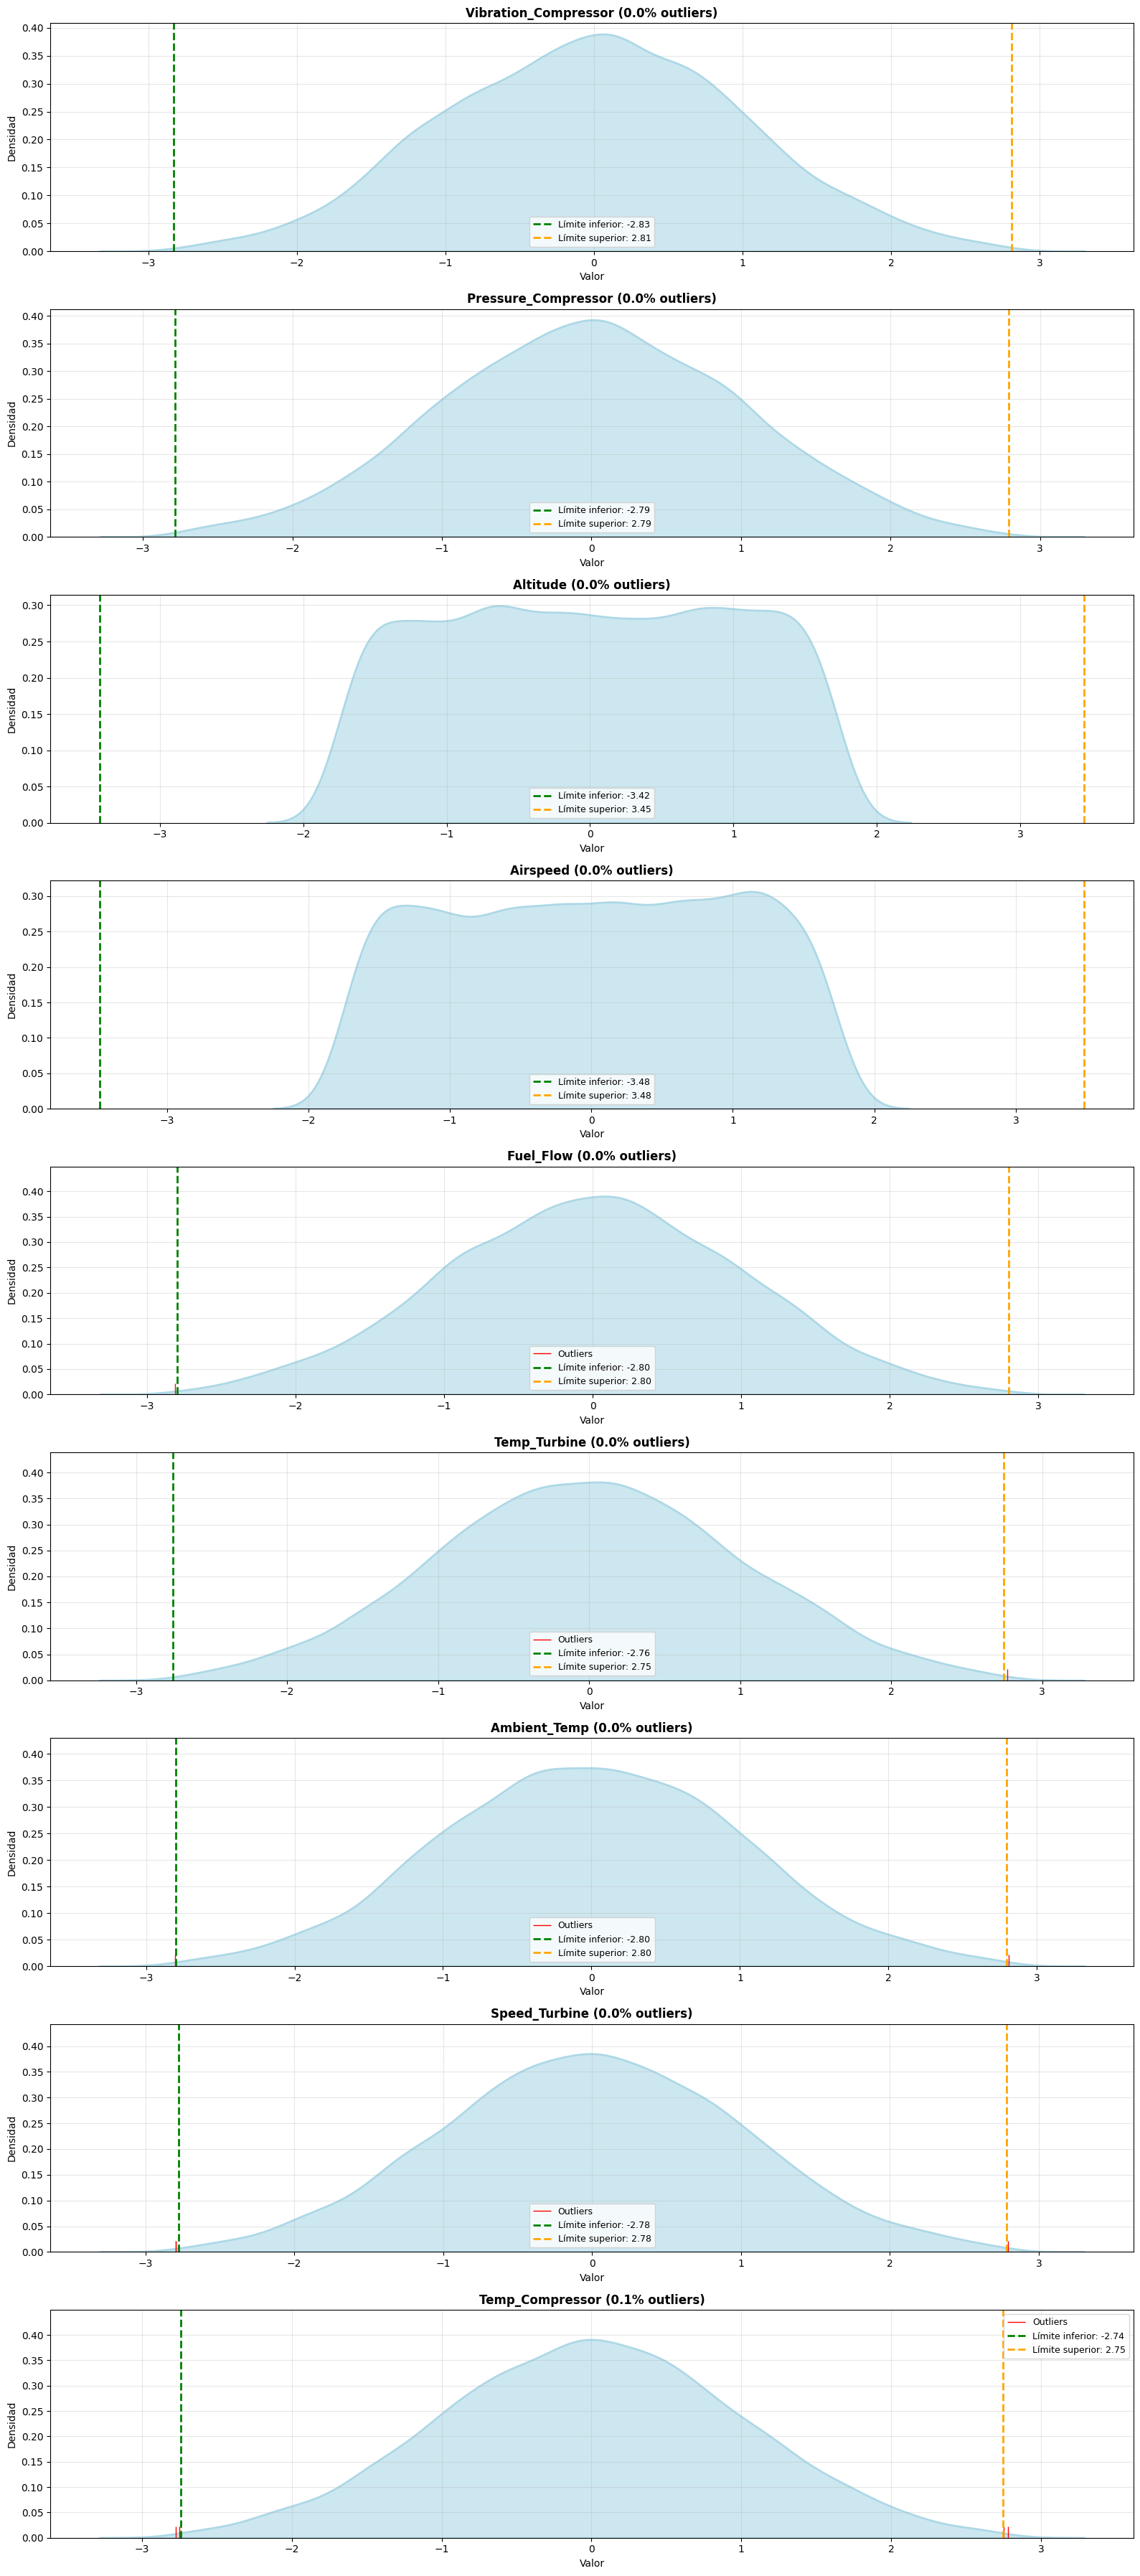

In [49]:
from utils import generar_df_estadisticas_outliers
from plots import plot_distribuciones_outliers


#Obtenemos la información necesaria para el plot
resultados_df = generar_df_estadisticas_outliers(df)

#Graficar las distribuciones
fig = plot_distribuciones_outliers(df, resultados_df)
plt.tight_layout() #Para una mejor visualizacion (que no se solapen los plots)
plt.show(fig)


Observamos que los datos presentan una media cercana a cero, lo cual confirma que estaban previamente normalizados, tal como se esperaba. Es por ello que obtaremos por conservar los outliers detectados como parte de la dataset.

## Correlación entre variables

A continuación, investigaremos si existe alguna relación entre los sensores disponibles (columnas numéricas). Esto nos permitirá **identificar posibles dependencias** entre ellos y, en caso de encontrar sensores altamente correlacionados, considerar la posibilidad de eliminar aquellos redundantes. De esta manera, podremos **simplificar el modelo sin perder información relevante y mejorar la eficiencia del análisis**.

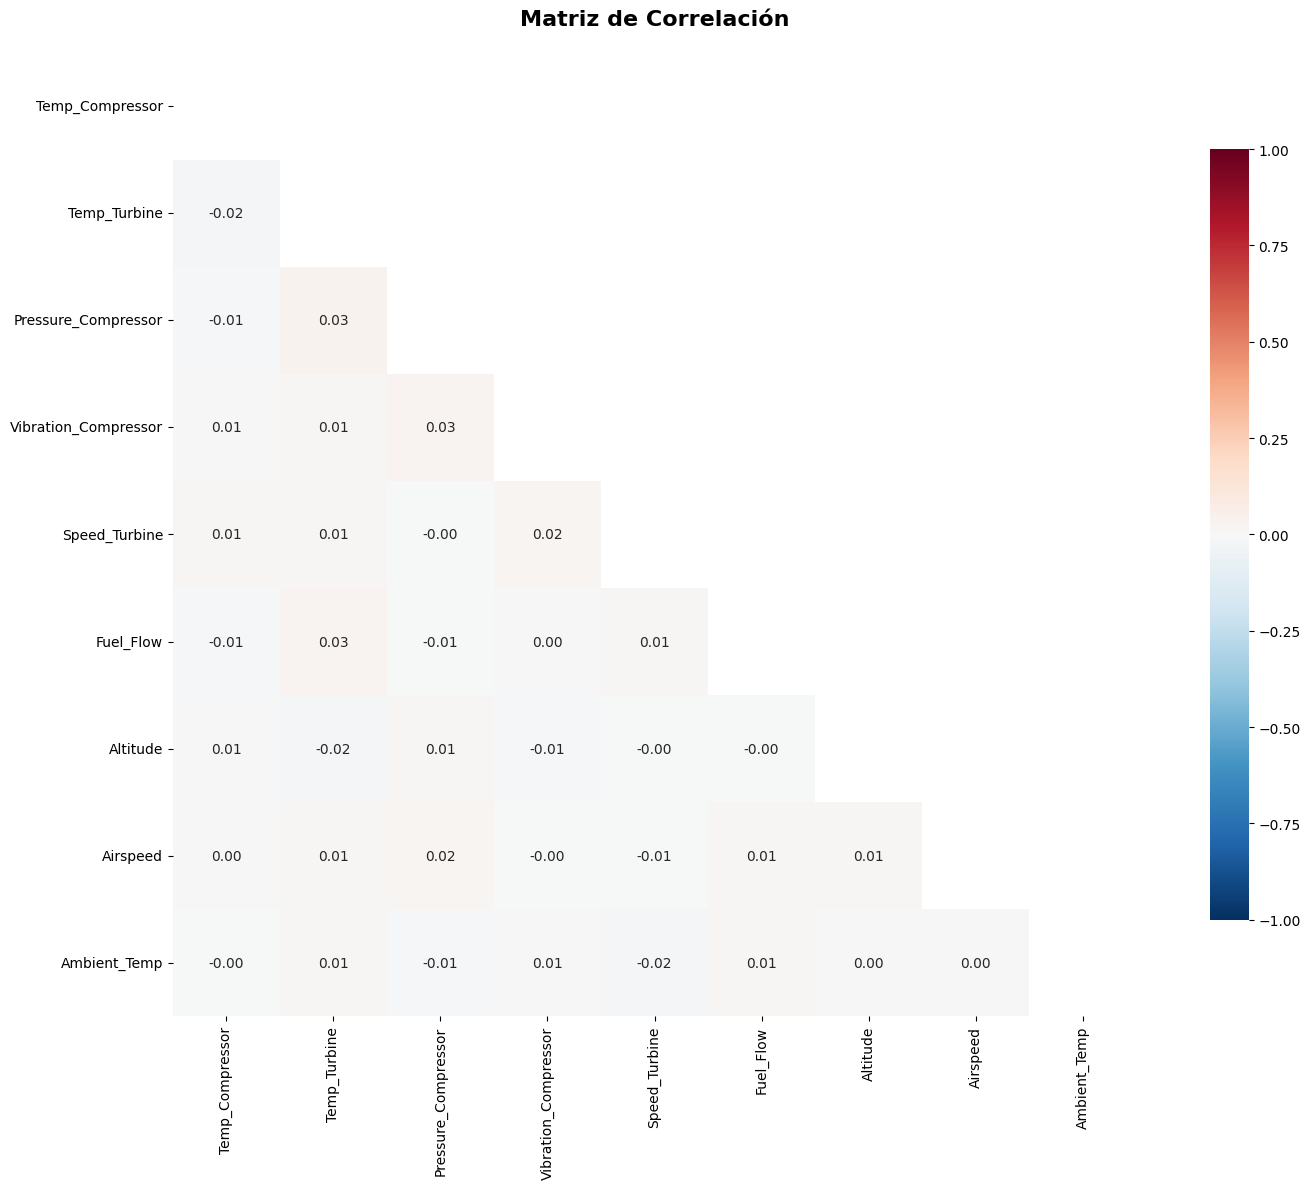

In [50]:
from utils import calculo_matriz_correlacion
from plots import plot_correlacion_heatmap

#Calcular la matriz de correlación
numeric_cols = ['Temp_Compressor','Temp_Turbine','Pressure_Compressor','Vibration_Compressor',
                'Speed_Turbine','Fuel_Flow','Altitude','Airspeed','Ambient_Temp']

corr_matrix = calculo_matriz_correlacion(df, numeric_cols)

#Graficar el heatmap
fig = plot_correlacion_heatmap(corr_matrix)
plt.tight_layout()
plt.show() 

Como se observa, los sensores son independientes entre sí, ya que la correlación entre ellos ronda cero. Esto indica que **ningún sensor es redundante**, lo que implica que cada uno aporta información única al análisis.

Si lo trasladamos al dominio real, esto tiene sentido ya que cada sensor captura fenómenos independientes, sin relaciones lineales simples entre ellos. Además, es probable que los fallos afecten a múltiples sensores de manera compleja, reflejando la interacción real de los sistemas del motor.

## Análisis de distribución de fallos

Con el objetivo de profundizar en el entendimiento de los datos, analizaremos la distribución de los fallos, que es la variable más importante en nuestro caso ya que es el objetivo a predecir.

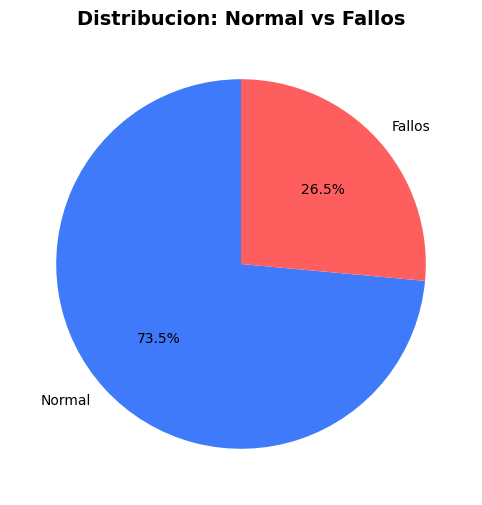

In [51]:
from plots import pie_chart

df["fallo"] = np.where(df["Fault_Label"] == "Normal", "Normal", "Fallos")
fig = pie_chart(df, "fallo", paleta = ["#3f7afa", "#ff5e5e"], titulo="Distribucion: Normal vs Fallos")
plt.show(fig)

Como se puede observar, existe un **gran desbalance entre los datos** sin fallo y los datos con fallo. Esto puede afectar negativamente al modelo, ya que podría tender a predecir mayoritariamente la clase más frecuente, ignorando los casos de fallo y reduciendo su capacidad de detectar eventos importantes. De hecho, si el modelo predijera todas las observaciones como normales, alcanzaría un accuracy del 73,54 %, lo que refleja que la métrica por sí sola no sería suficiente para evaluar su rendimiento.

Para comprender mejor el contexto, vamos a desglosar los datos según los distintos tipos de fallo, lo que nos permitirá identificar patrones específicos y la distribución de cada categoría dentro del dataset.

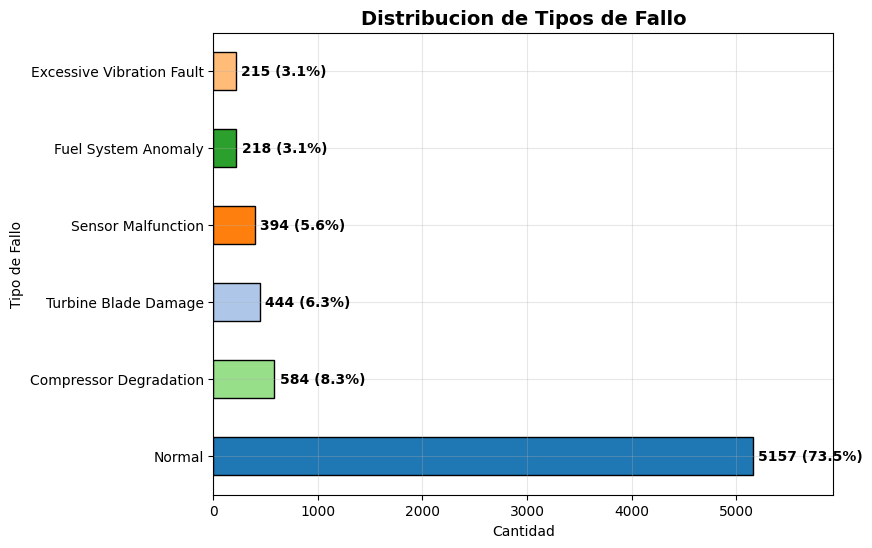

In [52]:
from utils import definicion_paleta
from plots import bar_chart

paleta = definicion_paleta(df, "Fault_Label")
fig = bar_chart(df, "Fault_Label", paleta, "Distribucion de Tipos de Fallo", "Cantidad", "Tipo de Fallo")
plt.show(fig)

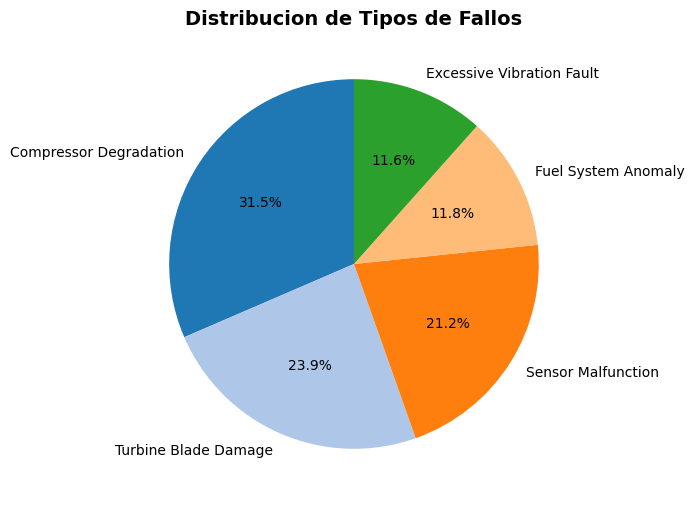

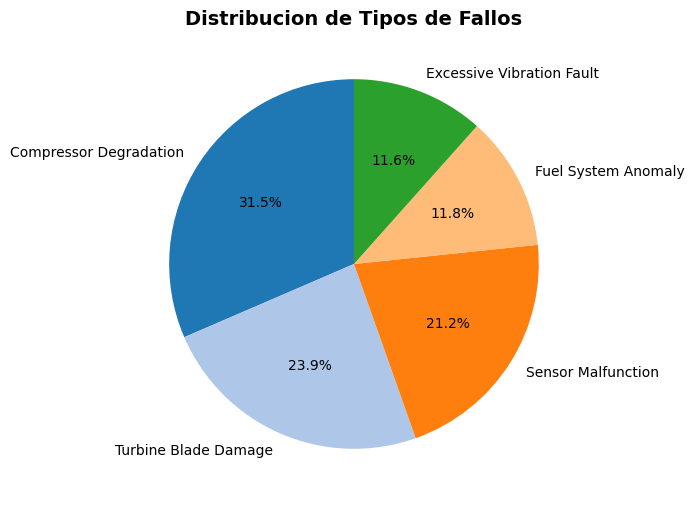

In [53]:
from plots import pie_chart

df_fallos = df[df['Fault_Label'] != 'Normal']
pie_chart(df_fallos, "Fault_Label", titulo="Distribucion de Tipos de Fallos")

Podemos observar que la distribución entre los distintos tipos de fallo es más variada, indicando que algunos errores ocurren con mayor frecuencia que otros y que existe diversidad en la aparición de los fallos dentro del dataset.

## Análisis de sensores

A continuación, intentaremos verificar si existe alguna relación entre los sensores y fallos específicos. A modo de ejemplo, podríamos observar que un fallo en la temperatura del compresor podría estar asociado con un aumento en la velocidad de la turbina, lo que nos permitiría identificar patrones de comportamiento entre sensores y tipos de fallo.

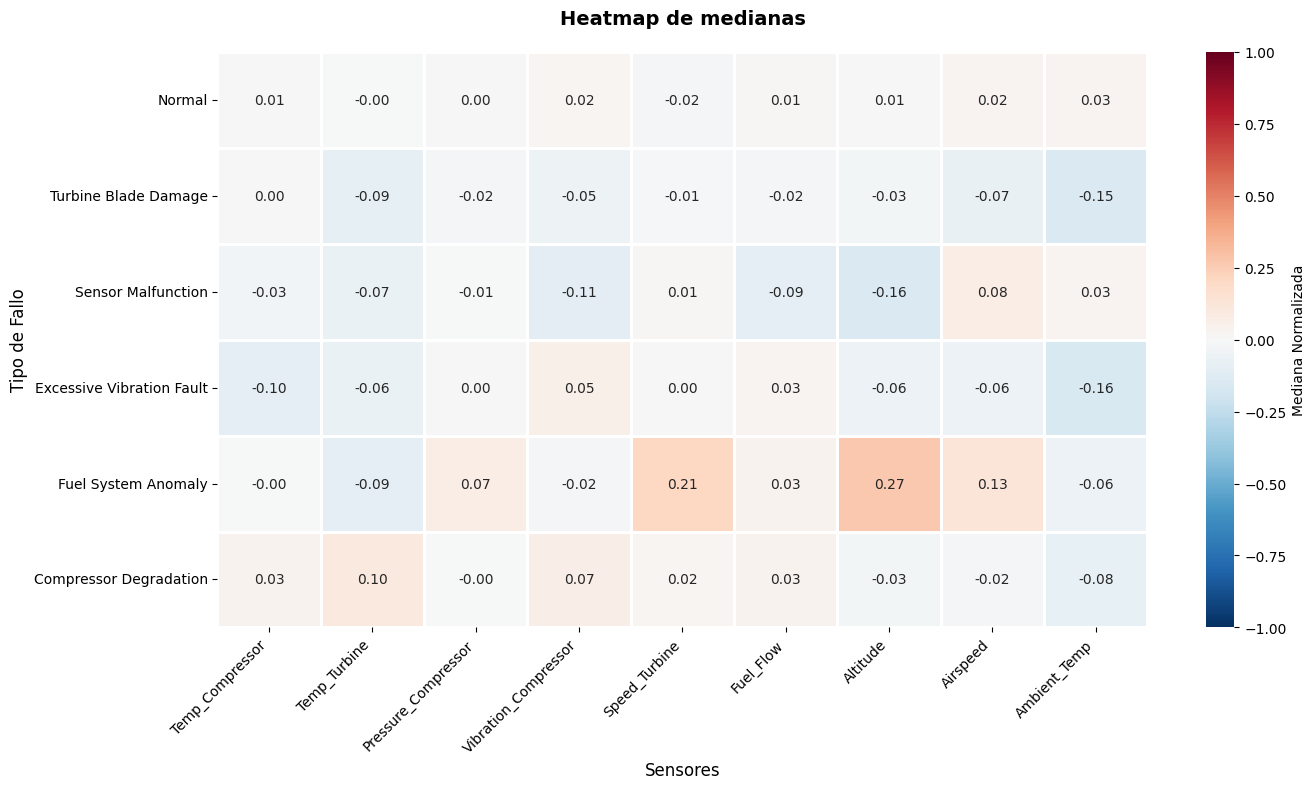

In [54]:
from utils import calcular_medianas_por_fallo
from plots import plot_heatmap_medianas

fallos = ['Normal', 'Turbine Blade Damage', 'Sensor Malfunction', 'Excessive Vibration Fault', 'Fuel System Anomaly', 'Compressor Degradation']

sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

median_matrix = calcular_medianas_por_fallo(df, fallos, sensores_principales)
plot_heatmap_medianas(median_matrix)
plt.tight_layout()
plt.show()



In [55]:
from utils import analisis_patrones_por_fallo

analisis_patrones_por_fallo(fallos, median_matrix)

Análisis de patrones por fallo:
--------------------------------

Normal:
  Sensor más CARACTERÍSTICO: Ambient_Temp (0.03)

Turbine Blade Damage:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.15)

Sensor Malfunction:
  Sensor más CARACTERÍSTICO: Altitude (-0.16)

Excessive Vibration Fault:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.16)

Fuel System Anomaly:
  Sensor más CARACTERÍSTICO: Altitude (0.27)

Compressor Degradation:
  Sensor más CARACTERÍSTICO: Temp_Turbine (0.10)


La decisión de utilizar la mediana en lugar de la media se basa en la necesidad de evitar que lecturas puntuales erróneas de los sensores distorsionen los resultados. La media puede verse fácilmente afectada por outliers, mientras que la mediana proporciona un valor más robusto frente a estos casos. Aunque en nuestro dataset los datos están limpios, esta práctica asegura que el análisis siga siendo fiable si se aplicara a conjuntos de datos con posibles errores o mediciones atípicas.

La mayoría de los fallos tienen como sensor más característico uno que mide valores ambientales, no del motor:
- *Ambient_Temp*: 3 de 6 fallos
- *Altitude*:  2 de 6 fallos

Que estos sensores aparezcan como predictores principales no tiene sentido físico, ya que un fallo de motor no debería depender de la hora del día o de la altitud. A modo de ejemplo, si quisiéramos predecir si una persona está enferma, deberíamos medir fiebre o tos, no si es de día o de noche. Aunque una degradación de algún componente podría afectar ligeramente la altitud, no debería ser un sensor principal para detectar fallos.

Esto sugiere dos posibles causas:
1. El dataset puede contener errores al haber recogido los datos.
2. Los fallos podrían ocurrir en condiciones ambientales específicas, aunque esto parece poco probable, ya que la matriz de correlación entre sensores no muestra relaciones significativas.

Ahora vamos a verificar si esto es cierto o si se trata de un posible error del dataset.

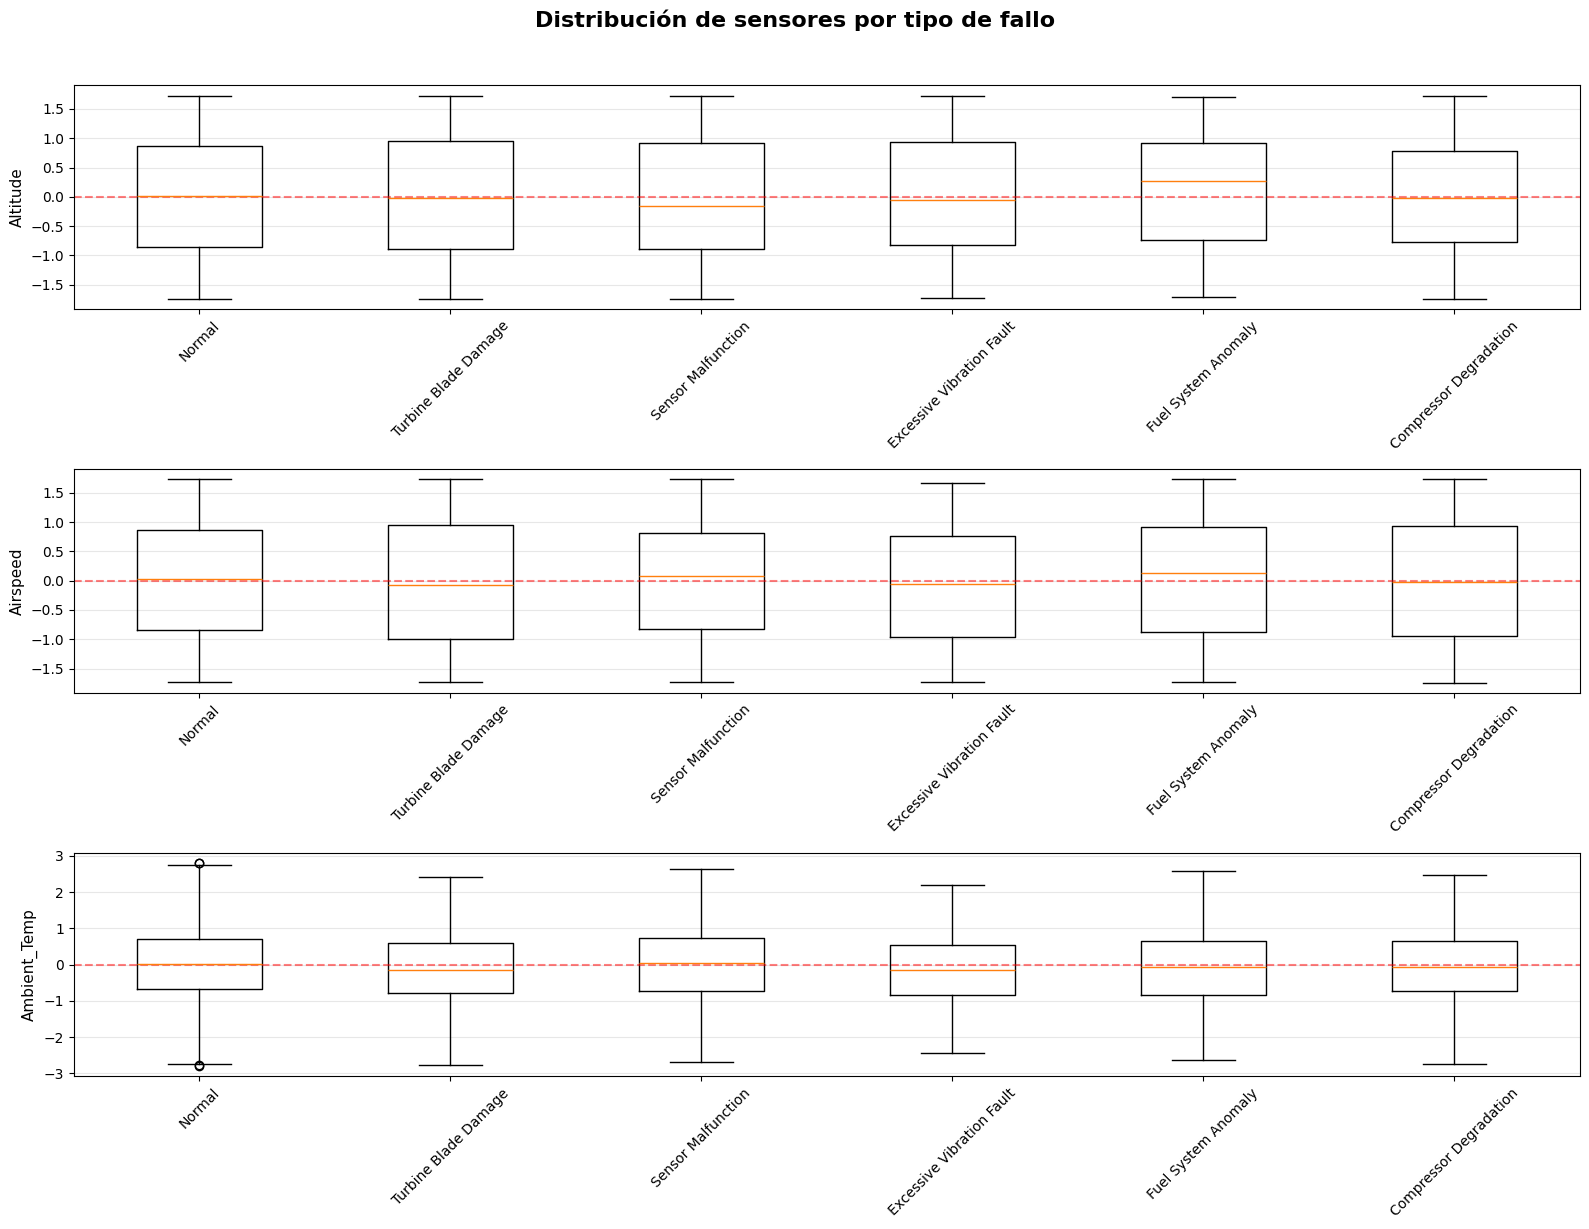

In [56]:
from plots import boxplots_por_sensor

sensores_ambientales = ["Altitude", "Airspeed", "Ambient_Temp"]

fallos = ['Normal', 'Turbine Blade Damage', 'Sensor Malfunction', 'Excessive Vibration Fault', 'Fuel System Anomaly', 'Compressor Degradation']

fig = boxplots_por_sensor(df, sensores_ambientales, fallos)
plt.tight_layout()
plt.show(fig)

Como se ve en los boxplots de los sensores ambientales, las medianas están cerca de cero. Esto indica que los fallos no dependen de variables ambientales, por lo que los datos están correctos en este aspecto.

El motivo de que algunos sensores aparezcan como destacados es simplemente que en un heatmap normalizado siempre habrá un valor más alto y uno más bajo. Esto no significa que ese sensor cause el fallo, solo que tiene la mayor diferencia relativa respecto a los demás.

Para comprender mejor el dominio y extraer *insights*, consideramos conveniente realizar un análisis exhaustivo de las relaciones y cambios entre los sensores cuando ocurre un fallo. Por ello, vamos a analizar estos patrones con mayor profundidad.

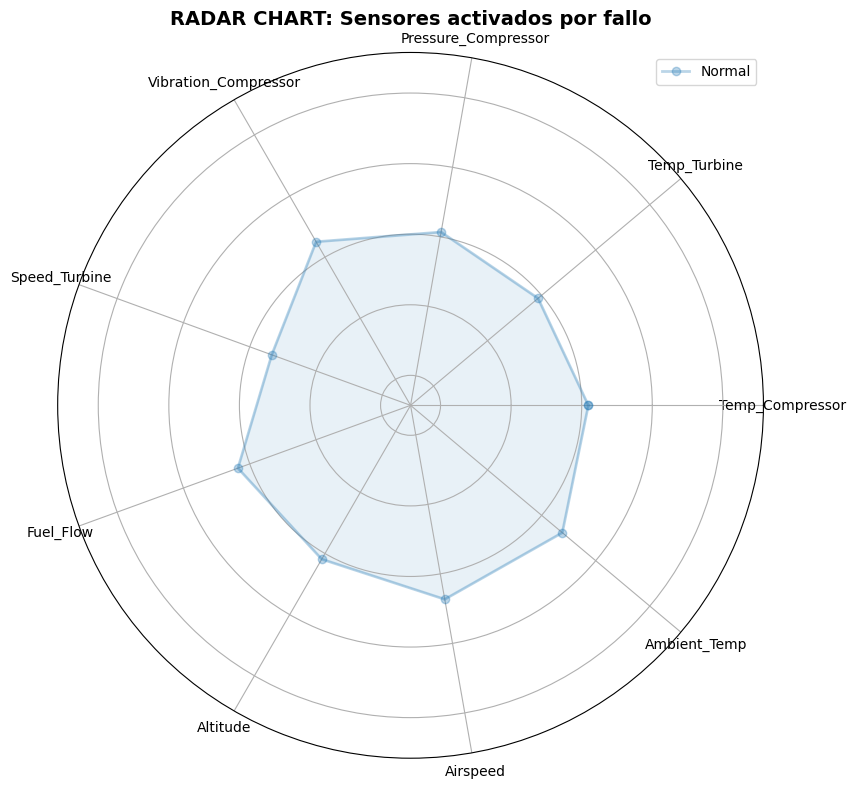

In [57]:
from plots import radar_plot

fallos = ['Normal']
sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
)

plt.tight_layout()
plt.show(fig)

Recordemos que todos los valores están **normalizados**, lo que permite compararlos bajo una misma escala. No obstante, para facilitar la visualización, el gráfico utiliza un factor de **amplitud**, ya que de lo contrario las diferencias eran mínimas y no se apreciaban los cambios.

En el caso **Normal** (base de comparación): los sensores forman un patrón relativamente regular (no perfecto, porque en la vida real siempre hay cierta variabilidad). Este patrón sirve como referencia,cualquier fallo que se desvíe significativamente de él puede considerarse una anomalía.

Teniendo ya definida la estructura de los sensores en una situación normal, ahora vamos a analizar qué sensores se activan ante cada tipo de fallo. No estudiaremos todos los casos, pero sí algunos ejemplos representativos que nos permitan entender de forma general cómo se comportan los sensores cuando ocurre un fallo.

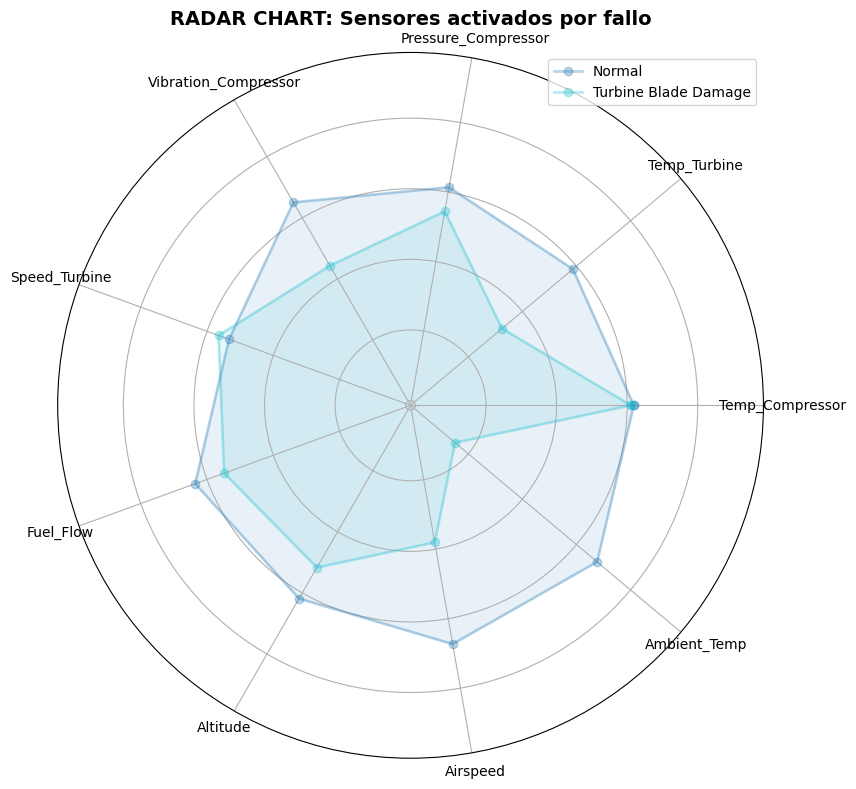

In [58]:
fallos = ['Normal', 'Turbine Blade Damage']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales
)

plt.tight_layout()
plt.show(fig)


<!-- - **Turbine Blade Damage**: Los sensores que más destacan son *Temp_Turbine*, *Ambient_Temp*, *Airspeed* y *Vibration_Compressor*. Esto se explica físicamente ya que si la turbina está dañada, no extrae energía eficientemente, los gases pasan sin interactuar y la turbina se “apaga”, es decir no hace esfuerzo y por tanto, la temperatura baja. Además, el sistema reduce carga para protegerse, disminuyendo la vibración. -->

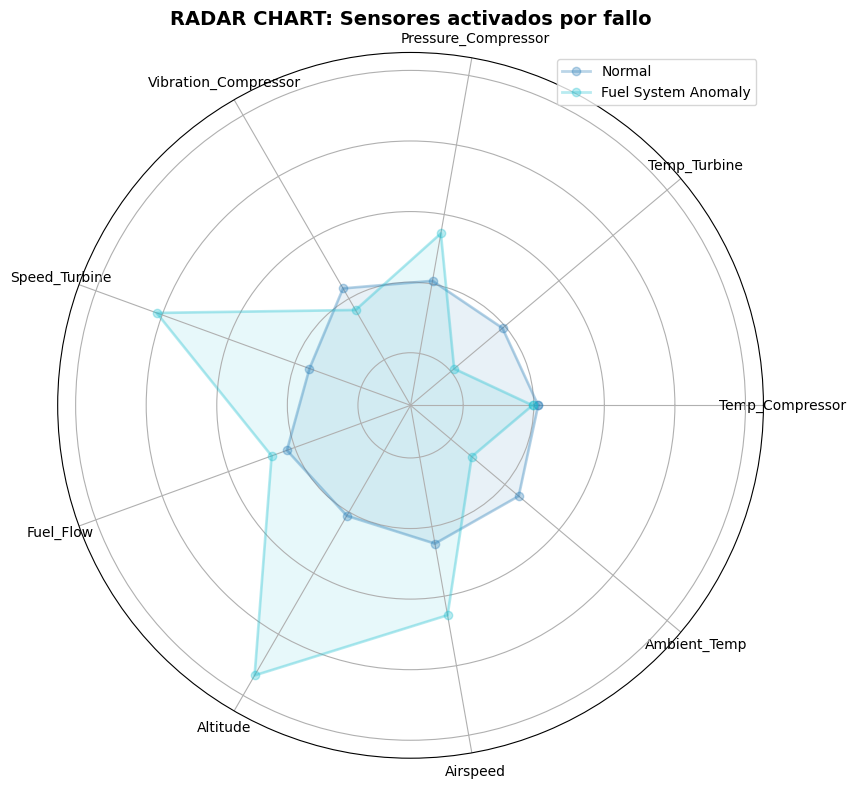

In [59]:
fallos = ['Normal', 'Fuel System Anomaly']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
    factor=2
)

plt.tight_layout()
plt.show(fig)


- **Fuel System Anomaly**: En este caso parece que se inyecte más combustible de lo normal. Es por ello que el motor aumenta sus RPM (Speed_Turbine) para quemar el exceso. Este exceso de combustible provoca que la cámara se enfríe (Temp_Turbine), lo cual es un aspecto clave para interpretar los sensores. Como consecuencia, se genera más potencia temporalmente, lo que hace que el avión acelere (Airspeed) y ascienda (Altitude).

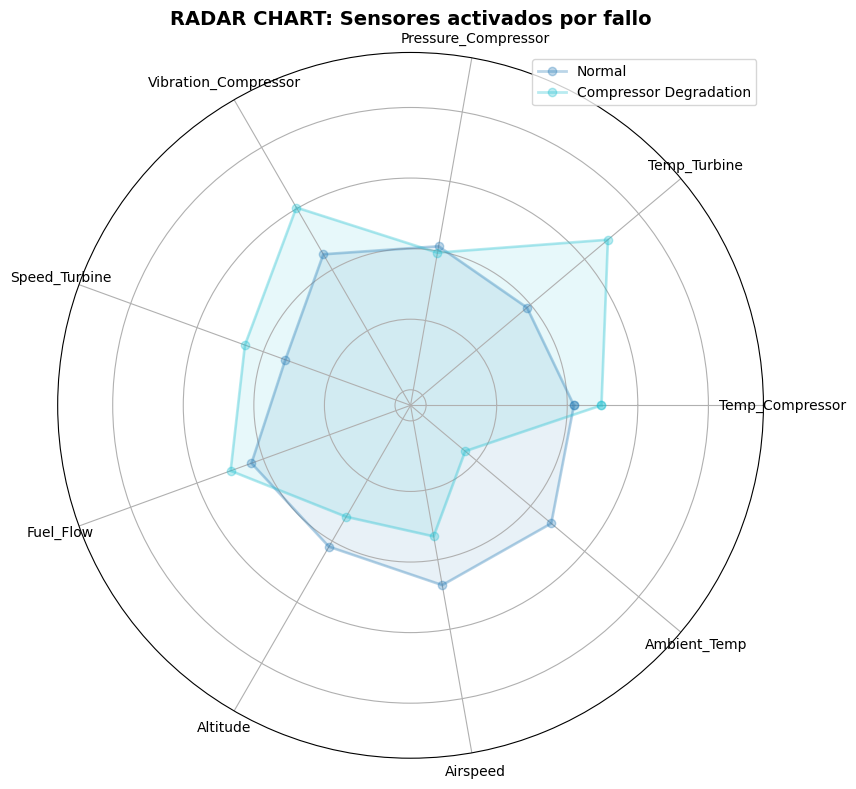

In [60]:
fallos = ['Normal', 'Compressor Degradation']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
)

plt.tight_layout()
plt.show(fig)

- **Compressor Degradation**: El sensor vibration_Compressor aumenta por desbalance mecánico, Temp_Turbine aumenta debido al aire mal comprimido y gases más calientes, y Airspeed disminuye reflejando la pérdida de eficiencia del motor, ya que el aumento de temperatura no se traduce en potencia útil.

Hemos analizado algunos ejemplos de lo que ocurre cada vez que se detecta un cambio en los sensores. Este problema resulta complejo, ya que un fallo no se refleja en un único sensor, sino en varios simultáneamente. Además, muchos cambios consideran variaciones en temperatura ambiente, airspeed o altitud, pero en realidad el modelo no debería basarse en estos valores para determinar un fallo, ya que no son causales directos del error.

Por ello, vamos a intentar **identificar patrones en los sensores a lo largo del tiempo**. Para ello, utilizaremos un gráfico que muestre la evolución de los sensores durante las cinco horas previas a un fallo específico, con el objetivo de verificar si se repiten ciertos patrones antes de que ocurra el error.

Podríamos probar siguiendo los cambios de sensores que hemos visto en el radar char:

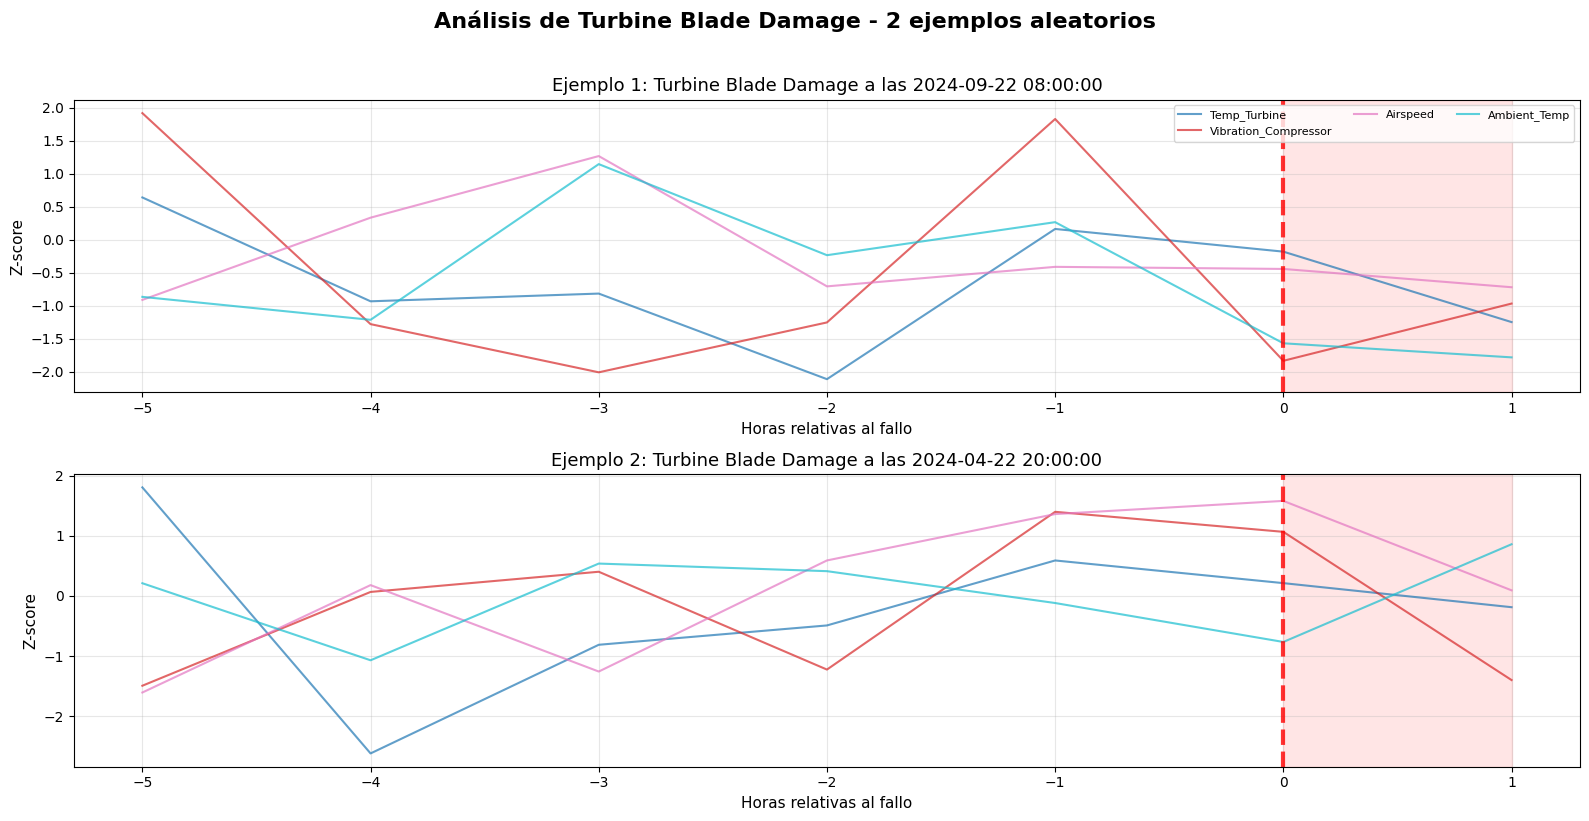

In [61]:
from plots import timeline_por_tipo_fallo

sensores_principales = ['Temp_Turbine',
                        'Vibration_Compressor', 'Airspeed', 'Ambient_Temp']

fig, ejemplos_turbine = timeline_por_tipo_fallo(df, sensores=sensores_principales, fallo='Turbine Blade Damage', n_ejemplos=2)

plt.tight_layout()
plt.show(fig)

O incluso todos los sensores:

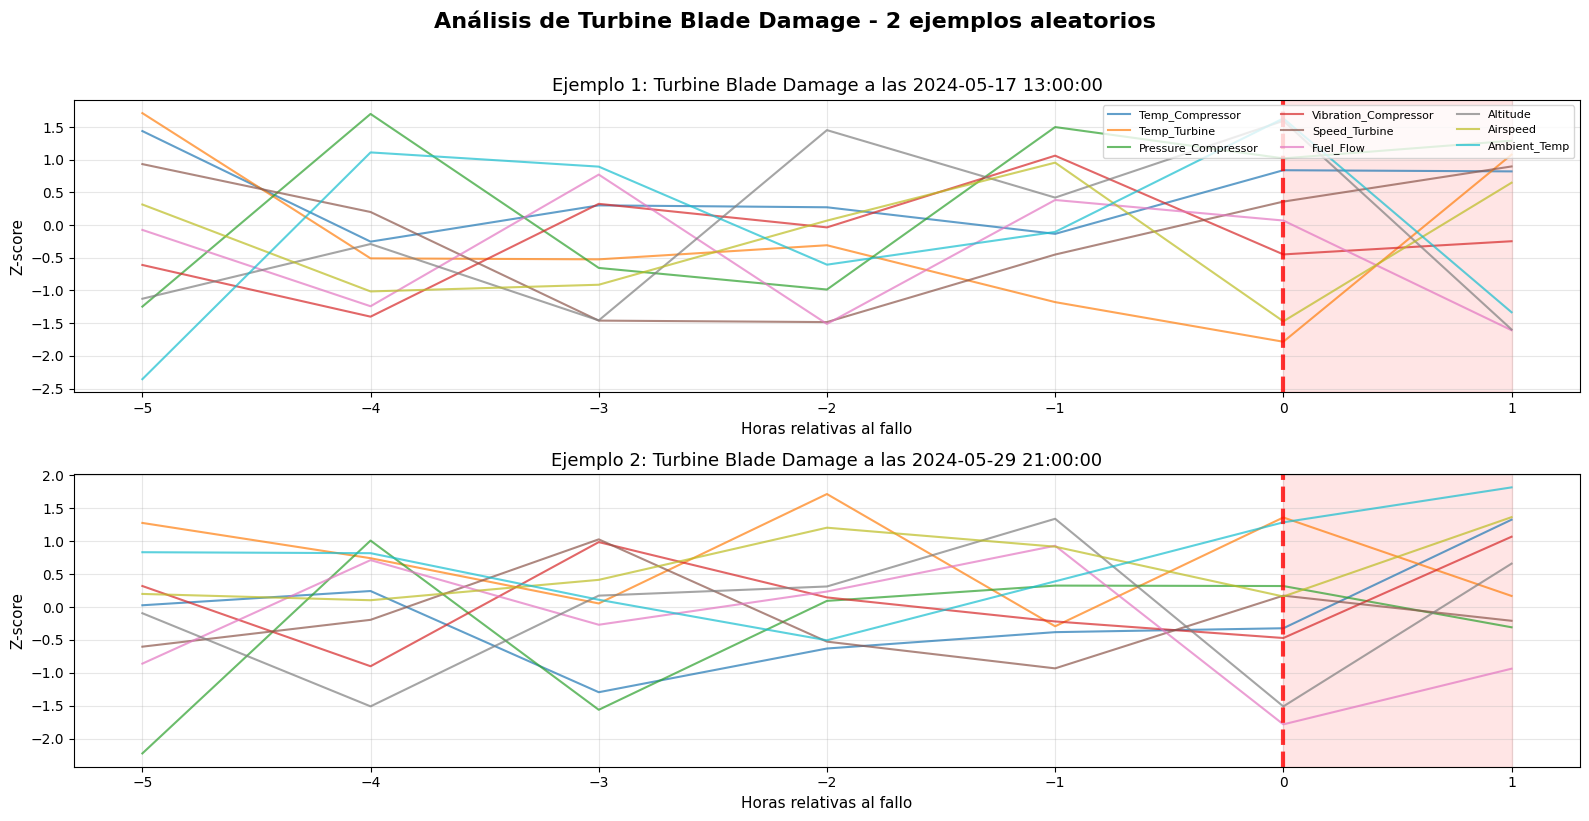

In [62]:
sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

fig, ejemplos_turbine = timeline_por_tipo_fallo(df, sensores=sensores_principales, fallo='Turbine Blade Damage', n_ejemplos=2)

plt.tight_layout()
plt.show(fig)

Consideramos conveniente medir los fallos de manera cuantitativa. Por ello, en esa misma ventana de horas, podemos calcular el cambio promedio de los sensores, lo que nos permitirá evaluar numéricamente la magnitud de los cambios antes de un fallo.

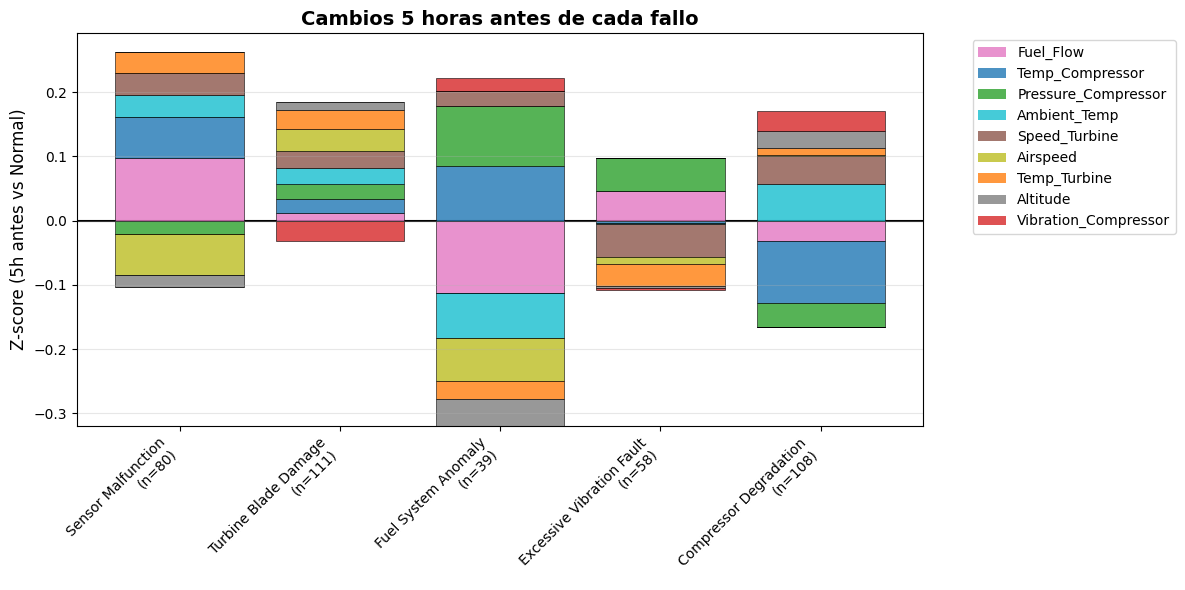

In [63]:
from plots import plot_cambio_5h

fig = plot_cambio_5h(df, sensores_principales)
plt.tight_layout()
plt.show(fig)

Podemos observar que la distribución de los cambios en los sensores **varía según el tipo de fallo**. No obstante, continúa predominando un patrón de diferencias mínimas, lo que puede dificultar la detección de fallos por parte de los modelos.

## Síntesis de observaciones

A modo de resumen, hemos identificado varios aspectos clave a tener en cuenta para el desarrollo de nuestros modelos:

- **Datos normalizados**: Los datos ya vienen normalizados en z-score, lo que permite compararlos bajo una misma escala y facilita el análisis sin necesidad de un preprocesamiento adicional.

- **Correlación entre sensores**: No existe correlación significativa entre los sensores, lo que indica que cada uno mide un fenómeno distinto y no hay redundancia entre ellos. Esto refuerza la idea de que todos aportan información única.

- **Distribución de fallos**: El dataset presenta un fuerte desbalance, con un 73,5 % de casos normales frente a un 26,5 % con fallos. Será necesario considerar modelos que manejen bien este tipo de desbalances o aplicar técnicas de resampling (oversampling, undersampling o SMOTE).

- **Sensores predominantes**: Los sensores con mayor peso aparente son los que miden condiciones ambientales, aunque esto se debe a que *uno tenía que serlo*, ya que las diferencias entre sensores son mínimas. Para evitar sesgos en el modelo, podría ser conveniente probar entrenamientos sin estos sensores y evaluar si mejora la precisión.

- **Fallos sin consistencia temporal**: No se observan patrones claros en las horas previas a un fallo específico, lo que complica la detección temprana y sugiere que las relaciones entre sensores y fallos podrían ser no lineales o de naturaleza más compleja.